# Bonstons

#### Imports di base

In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("C:/Users/giann/Documents/GitHub/Bostonshouse/boston.csv")

### Ricerca delle features più adeguate

Colonna 'CRIM': 1 correlazioni forti
RAD    0.625505
Name: CRIM, dtype: float64
----------------------------------------
Colonna 'ZN': 1 correlazioni forti
DIS    0.664408
Name: ZN, dtype: float64
----------------------------------------
Colonna 'INDUS': 5 correlazioni forti
NOX      0.763651
TAX      0.720760
AGE      0.644779
LSTAT    0.603800
DIS     -0.708027
Name: INDUS, dtype: float64
----------------------------------------
Colonna 'CHAS': 0 correlazioni forti
Colonna 'NOX': 5 correlazioni forti
INDUS    0.763651
AGE      0.731470
TAX      0.668023
RAD      0.611441
DIS     -0.769230
Name: NOX, dtype: float64
----------------------------------------
Colonna 'RM': 2 correlazioni forti
MEDV     0.695360
LSTAT   -0.613808
Name: RM, dtype: float64
----------------------------------------
Colonna 'AGE': 4 correlazioni forti
NOX      0.731470
INDUS    0.644779
LSTAT    0.602339
DIS     -0.747881
Name: AGE, dtype: float64
----------------------------------------
Colonna 'DIS': 4 correl

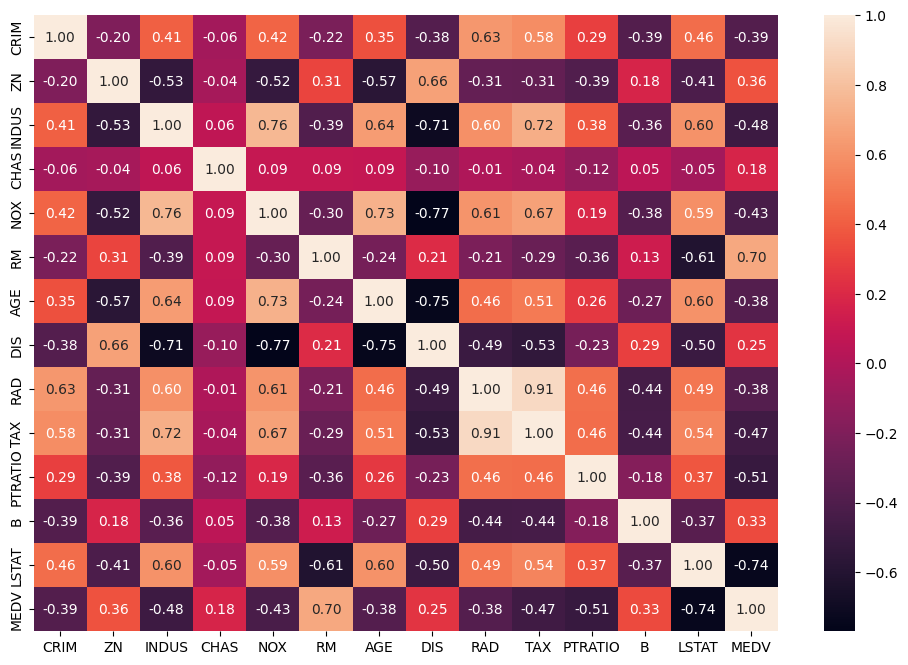

In [80]:
corr = df.corr()
# Stampa tutte le correlazioni con valore maggiore di 0.5 per ogni colonna
threshold = 0.6
for col in corr.columns:
    high_corr = corr[col][(corr[col].abs() > threshold) & (corr[col].abs() < 1)]
    high_corr = high_corr.reindex(high_corr.sort_values(ascending=False).index)
    print(f"Colonna '{col}': {len(high_corr)} correlazioni forti")
    if not high_corr.empty:
        print(high_corr)
        print("-" * 40)

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

Con i dati qui sopra scegliamo le features RM e LSTAT. Sono quelle con le correlazioni più alte.

## Regressione non lineare

In [81]:
X = df[['RM', 'LSTAT']]
y = df['MEDV']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficienti
print("Coefficiente RM:", model.coef_[0])
print("Coefficiente LSTAT:", model.coef_[1])
print("Intercetta:", model.intercept_)

# Predizione e R2
y_pred = model.predict(X_test)
print("R² score:", r2_score(y_test, y_pred))


Coefficiente RM: 5.109068459170831
Coefficiente LSTAT: -0.6549487926811649
Intercetta: -1.2625286844374557
R² score: 0.5409084827186418


In [82]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

MSE: 37.38
R²: 0.54


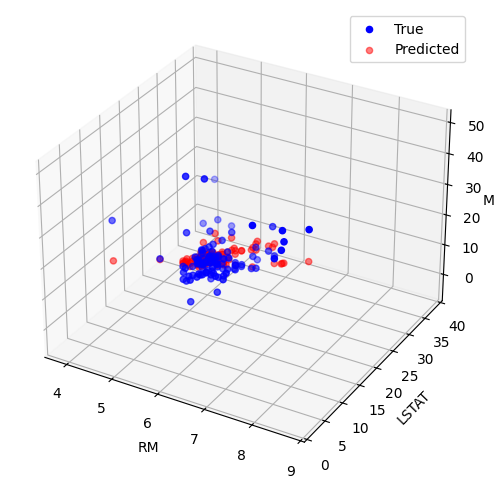

In [83]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['RM'], X_test['LSTAT'], y_test, color='blue', label='True')
ax.scatter(X_test['RM'], X_test['LSTAT'], y_pred, color='red', label='Predicted', alpha=0.5)

ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV')
ax.legend()
plt.show()


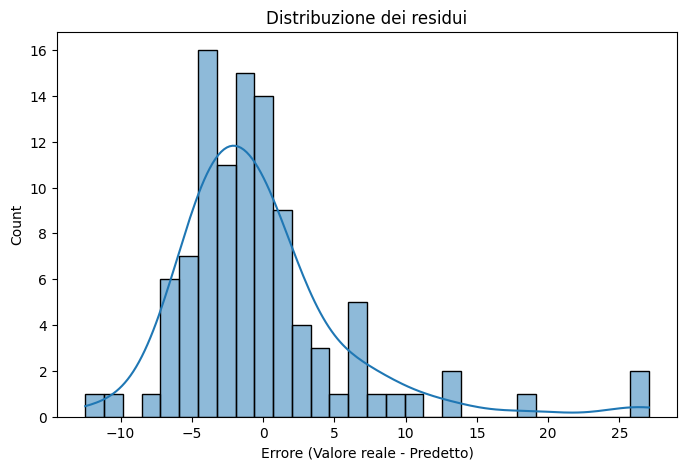

In [84]:
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribuzione dei residui")
plt.xlabel("Errore (Valore reale - Predetto)")
plt.show()

In [87]:
# Calcolo metriche di errore
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE (Errore quadratico medio): {mse:.2f}")
print(f"RMSE (Radice dell'errore quadratico medio): {rmse:.2f}")
print(f"MAE (Errore assoluto medio): {mae:.2f}")
print(f"R² (R-quadro): {r2:.2f}")

MSE (Errore quadratico medio): 37.38
RMSE (Radice dell'errore quadratico medio): 6.11
MAE (Errore assoluto medio): 4.14
R² (R-quadro): 0.54
